In [1]:
# imports
import numpy as np
import pandas as pd
from pathlib import Path
import json
import yaml
from tqdm import tqdm
import pickle
import librosa
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import random

import torch
from datasets import Dataset, DatasetDict, load_metric
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Processor, Wav2Vec2CTCTokenizer, Wav2Vec2ForCTC, TrainingArguments, Trainer
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Convert the dataset imported from the pkl files into a DatasetDict object for training on the transformers later

In [2]:
# load the pickle data file
with open('./pkl/magister_data_flac_16000_train.pkl', 'rb') as f:
    df_train = pickle.load(f)

with open('./pkl/magister_data_flac_16000_dev.pkl', 'rb') as f:
    df_dev = pickle.load(f)

In [3]:
# make it into a DatasetDict Object
dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "dev": Dataset.from_pandas(df_dev)
})

# check the format of the DatasetDict
dataset

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'text'],
        num_rows: 1818
    })
    dev: Dataset({
        features: ['file', 'audio', 'text'],
        num_rows: 360
    })
})

In [4]:
# further preprocessing of the dataset for the transformers
def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched" to ensure mapping is correct
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names["train"], num_proc=1)

In [ ]:
# check the format of the DatasetDict again with the required values needed for the training later
dataset

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'text'],
        num_rows: 1818
    })
    dev: Dataset({
        features: ['file', 'audio', 'text'],
        num_rows: 360
    })
})

In [54]:
# make a list to get the list of audio length of all the training data
audio_length_list = []
for idx, item in tqdm(enumerate(dataset['train'])):
    audio_length_list.append(dataset['train'][idx]['input_length'])

0it [00:00, ?it/s]


KeyError: 'input_length'

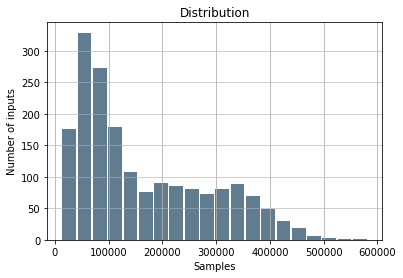

In [61]:
# get the distribution of the audio sample
data_dist = pd.Series(audio_length_list)

data_dist.plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')
plt.title('Distribution')
plt.xlabel('Samples')
plt.ylabel('Number of inputs')
plt.grid(axis='y', alpha=0.75)

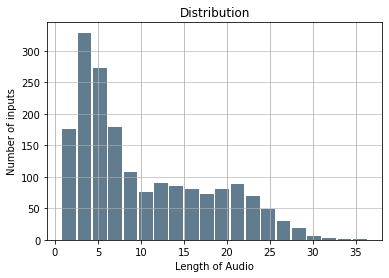

In [62]:
# get the distribution of the audio length (in 16k sample)
data_dist = pd.Series([audio_length/16000 for audio_length in audio_length_list])

data_dist.plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')
plt.title('Distribution')
plt.xlabel('Length of Audio')
plt.ylabel('Number of inputs')
plt.grid(axis='y', alpha=0.75)

In [65]:
# from the graph get the max sample length
MAX_SAMPLE_LENGTH = 475000

# filter out those longer duration videos (based on the histogram with the right tail minority)
dataset["train"] = dataset["train"].filter(lambda x: x < max_input_length_in_sec * MAX_SAMPLE_LENGTH, input_columns=["input_length"])

## Preparing the feature extractor and tokenizer

In [57]:
# extract all characters available in the train and dev datasets
def extract_all_chars(batch):
    all_text = " ".join(batch["text"])
    vocab = list(set(all_text))
    return vocab

In [67]:
# extract characters from train dataset
vocabs_train = extract_all_chars(df_train)

# extract characters from dev dataset
vocabs_dev = extract_all_chars(df_dev)

# create a union of all distinct letters in the training and the dev datasets
vocab_list = list(set(vocabs_train) | set(vocabs_dev))

# convert resulting list into an enumerated dictionary
vocab_dict = {v: k for k, v in enumerate(vocab_list)}

# replace space with a more visible character |
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

# add the [UNK] and the [PAD] token
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)

# vocabulary is completed, now save the vocabulary as a json file
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [60]:
# PREPARING THE TOKENIZER
# use the json file to instantiate an object of the Wav2Vec2CTCTokenizer class
tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

# PREPARING THE FEATURE EXTRACTOR
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)

# wrap the feature extractor and tokenizer as a single Wav2VevProcessor class object
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

## Set up the Trainer class for training

In [ ]:
@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)
data_collator